In [1]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import os
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
import split_valid

Using TensorFlow backend.


使用Xception模型

In [2]:
from keras.applications.xception import Xception, preprocess_input

In [3]:
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test1"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)

分割验证集

In [4]:
drivers_pd = pd.read_csv("data/drivers_img_nop081_list.csv")
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
choices = ["p022", "p039"]

In [5]:
split_valid.split(choice_ids=choices, 
                  train_pd_path="data/drivers_img_nop081_list.csv", 
                  train_aug_pd_path="data/drivers_img_aug_list.csv", 
                  train_dir=train_dir, 
                  val_dir=val_dir, 
                  test_dir=test_dir, 
                  origin_test_dir="data/imgs/test", 
                  saved_weights_dir="saved_weights")

选择作为验证集的司机ID: ['p022', 'p039']
分割的训练集数量: 20440 ，验证集数量: 1884
从增强数据集中分割的训练集数量: 20440
link images to directory data/imgs/train2
link augmented images to directory data/imgs/train2
link images to directory data/imgs/val2
split valid data done!


In [6]:
def get_im_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

图片预处理

In [7]:
# 图像生成器输出的图像大小
out_image_size = (299, 299)
batch_size = 32

In [8]:
# 训练集图像生成器
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1./255
)

# 验证集图像生成器
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 40880 images belonging to 10 classes.
Found 1884 images belonging to 10 classes.


构建模型

In [9]:
base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax', use_bias=False, kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions, name=base_model.name)

op = Adam(lr=0.00003, decay=1e-8)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

开始训练

In [10]:
# 训练代数
epochs = 20

save_file = saved_weights + '/' + model.name + '_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
callbacks = [
    ModelCheckpoint(save_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1, period=1),
    EarlyStopping(monitor="val_loss", verbose=1, mode="min", min_delta=0.0005, patience=3)
]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

model name: xception , will save weight file: saved_weights/xception_model.h5
Epoch 1/20
1278/1278 [==============================] - 1767s 1s/step - loss: 0.5795 - acc: 0.8896 - val_loss: 0.2757 - val_acc: 0.9676

Epoch 00001: val_loss improved from inf to 0.27570, saving model to saved_weights/xception_model.h5
Epoch 2/20
1278/1278 [==============================] - 1106s 865ms/step - loss: 0.1774 - acc: 0.9947 - val_loss: 0.2037 - val_acc: 0.9735

Epoch 00002: val_loss improved from 0.27570 to 0.20371, saving model to saved_weights/xception_model.h5
Epoch 3/20
1278/1278 [==============================] - 1115s 872ms/step - loss: 0.1142 - acc: 0.9974 - val_loss: 0.1294 - val_acc: 0.9851

Epoch 00003: val_loss improved from 0.20371 to 0.12944, saving model to saved_weights/xception_model.h5
Epoch 4/20
1278/1278 [==============================] - 1110s 869ms/step - loss: 0.0700 - acc: 0.9990 - val_loss: 0.1203 - val_acc: 0.9772

Epoch 00004: val_loss improved from 0.12944 to 0.12034, s

绘制图型

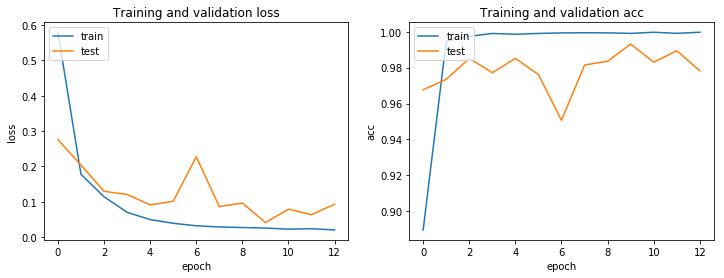

In [11]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

测试预测结果

In [12]:
from keras.models import load_model

pred_model = load_model("saved_weights/xception_model.h5")

预测所有测试集，并生成提交kaggle的报告

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
pred_batch_size=128

test_generator = test_datagen.flow_from_directory(test_dir, out_image_size, shuffle=False, 
                                             batch_size=pred_batch_size, class_mode=None)

test_generator.filenames[0]

Found 79726 images belonging to 1 classes.


'test/img_1.jpg'

In [14]:
sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = pred_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/pred_xception.csv', index=None)
print("predict done.")

623/623 [==============================] - 1353s 2s/step
y_pred shape (79726, 10)
              img       c0     c1     c2     c3     c4     c5     c6     c7  \
0       img_1.jpg  0.00500  0.005  0.005  0.005  0.005  0.995  0.005  0.005   
1      img_10.jpg  0.00500  0.005  0.005  0.005  0.005  0.995  0.005  0.005   
2     img_100.jpg  0.97565  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
3    img_1000.jpg  0.00500  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
4  img_100000.jpg  0.00500  0.005  0.005  0.995  0.005  0.005  0.005  0.005   

      c8        c9  
0  0.005  0.005000  
1  0.005  0.005000  
2  0.005  0.009832  
3  0.995  0.005000  
4  0.005  0.005000  
predict done.


提交到kaggle中后得到成绩：private:  0.30469, public: 0.35846